# 1. Introdução

Objetivo: O objetivo deste projeto é montar um banco de dados SQL na plataforma
Google Cloud Platform (GCP), consumir essa base no Google Colab e transformá-la
em DataFrames para análise de dados. O tratamento dos dados será realizado 
conforme necessário, e técnicas estatísticas serão aplicadas para suportar
decisões informadas.

# 2. Arquitetura

Este projeto consiste em três partes principais:

    1. Montvalor_aluguelm do banco de dados no GCP.
    2. Consumo da base no Google Colab e transformação em DataFrames.
    3. Tratamento de dados e análise estatística.

# 3. Passos para Montar o Banco de Dados no GCP

## 3.1. Criação do Banco de Dados SQL no GCP

1. Acesse o Google Cloud Console.
2. Navegue até a seção Cloud SQL e crie uma nova instância.
3. Escolha a versão do banco de dados (MySQL, PostgreSQL, etc.).
4. Importe a base de dados SQL fornecida, utilizando o comando de importação disponível no console ou por meio de gcloud

   ```bash
    gcloud auth login --no-launch-browser
    gcloud sql import sql mysql-soulcode gs://soulcode-analytics-data-bootcamp/projeto_logistica.sql
    ```
   

In [1]:
import os
import io
import math
import numpy as np
import pandas as pd
import mysql.connector
from mysql.connector import Error
from google.cloud import storage
from pyspark.sql import DataFrame, SparkSession
from unidecode import unidecode
from sqlalchemy import create_engine
from urllib.parse import quote_plus


from scipy import stats

from sqlalchemy import Column, Integer, Float, String, Boolean, DateTime, Text
from sqlalchemy.orm import declarative_base

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
credentials_path = "/home/jovyan/code/soulcode-434516-31276919e28c.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path

# 5. Consumindo o Banco de Dados no Google Colab

Configuração do Ambiente

1. Configure a conexão com o banco de dados no GCP

In [3]:
HOST = '34.16.33.165'
DB_LOCADORA = 'locadora'
DB_LOGISTICA = 'logistica'
DB_LOJA = 'loja'
DB_MARKETING_DIGITAL = 'marketing_digital'
DB_RH = 'rh'
USER = 'soulcode'
PASSWORD = 'Soulcode@!12pass'

## 5.1. Database Locadora

In [4]:
engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB_LOCADORA}')
connection = engine.connect()

### 5.1.1 Transformação em DataFrames Pandas

In [5]:
query = """SELECT
    a.codaluguel AS codigo_aluguel,
    a.data_aluguel AS data_aluguel,
    c.nome AS nome_cliente,
    c.cidade AS cidade_cliente,
    c.sexo AS sexo_cliente,
    c.estado AS estado_cliente,
    c.estadocivil AS estadocivil_cliente,
    car.modelo AS modelo_carro,
    car.valor AS valor_aluguel,
    m.marca AS marca_carro
FROM
    aluguel a
INNER JOIN cliente c ON a.codcliente = c.codcliente
INNER JOIN carro car ON a.codcarro = car.codcarro
INNER JOIN marca m ON car.codmarca = m.codmarca;"""

df = pd.read_sql(query, connection)
df

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen


### 5.1.2. Tratamento de Dados

**Analisando o dataset**

Dimensão do dataset:

In [6]:
df.shape

(10, 10)

Verificação de dados faltantes:

In [7]:
df.isnull().sum()

codigo_aluguel         0
data_aluguel           0
nome_cliente           0
cidade_cliente         0
sexo_cliente           0
estado_cliente         0
estadocivil_cliente    0
modelo_carro           0
valor_aluguel          0
marca_carro            0
dtype: int64

Verficando informações sobre sobre dataframe incluindo index, tipo dos dados e
colunas não nulas e uso da memoria

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codigo_aluguel       10 non-null     int64  
 1   data_aluguel         10 non-null     object 
 2   nome_cliente         10 non-null     object 
 3   cidade_cliente       10 non-null     object 
 4   sexo_cliente         10 non-null     object 
 5   estado_cliente       10 non-null     object 
 6   estadocivil_cliente  10 non-null     object 
 7   modelo_carro         10 non-null     object 
 8   valor_aluguel        10 non-null     float64
 9   marca_carro          10 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 932.0+ bytes


Analisando o dataframe, para identificar o tipo que corresponde aos dados

In [9]:
df.head()

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat


In [10]:
df.tail()

,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen


Verificando colunas numéricas com valores zerados

In [11]:
df.eq(0).sum()

codigo_aluguel         0
data_aluguel           0
nome_cliente           0
cidade_cliente         0
sexo_cliente           0
estado_cliente         0
estadocivil_cliente    0
modelo_carro           0
valor_aluguel          0
marca_carro            0
dtype: int64

Remover registro duplicados

Deletar registro duplicados

In [12]:
df = df.drop_duplicates()

 Conversão de Tipos de Dados

In [13]:
df['data_aluguel'] = pd.to_datetime(df['data_aluguel'], errors='coerce')
df['ano_aluguel'] = df['data_aluguel'].dt.year
df['mes_aluguel'] = df['data_aluguel'].dt.month
df['dia_aluguel'] = df['data_aluguel'].dt.day


### 5.1.3. Análise Estatística Descritiva

In [14]:
df.describe()

,codigo_aluguel,data_aluguel,valor_aluguel,ano_aluguel,mes_aluguel,dia_aluguel
count,10.00000,10,10.000000,10.0,10.0,10.000000
mean,5.50000,2023-04-10 19:12:00,132.000000,2023.0,4.0,10.800000
min,1.00000,2023-04-01 00:00:00,100.000000,2023.0,4.0,1.000000
25%,3.25000,2023-04-03 06:00:00,100.000000,2023.0,4.0,3.250000
50%,5.50000,2023-04-09 00:00:00,150.000000,2023.0,4.0,9.000000
75%,7.75000,2023-04-18 00:00:00,150.000000,2023.0,4.0,18.000000
max,10.00000,2023-04-25 00:00:00,170.000000,2023.0,4.0,25.000000
std,3.02765,NaN,28.205594,0.0,0.0,8.879439


In [15]:
# Matriz de correlação #TODO:estudar
# correlacao = df[['valor_aluguel', 'dia_aluguel']].corr()  # ou 'spearman' para correlação não linear
# correlacao

Boxplot e Identificação de Outliers

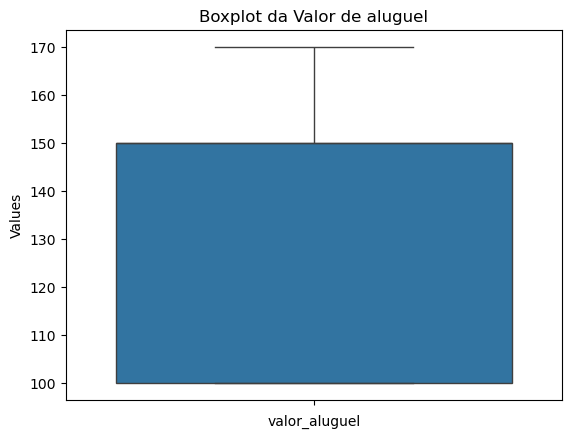

In [16]:
sns.boxplot(y='valor_aluguel', data=df)
plt.title('Boxplot da Valor de aluguel')
plt.xlabel('valor_aluguel')
plt.ylabel('Values')
plt.show()

Z-Score: Identifica outliers com base em quantos desvios padrão uma observação está distante da média

In [17]:
# z_scores = stats.zscore(df.select_dtypes(include=[float, int])) 
z_scores = stats.zscore(df['valor_aluguel'])
z_scores

0   -1.195896
1   -1.195896
2   -1.195896
3   -1.195896
4    0.672692
5    0.672692
6    0.672692
7    1.420127
8    0.672692
9    0.672692
Name: valor_aluguel, dtype: float64

In [18]:
outliers = df['valor_aluguel'][(z_scores > 3)]
outliers

Series([], Name: valor_aluguel, dtype: float64)

Histrograma para Frequência

In [19]:
n = len(df)
n

10

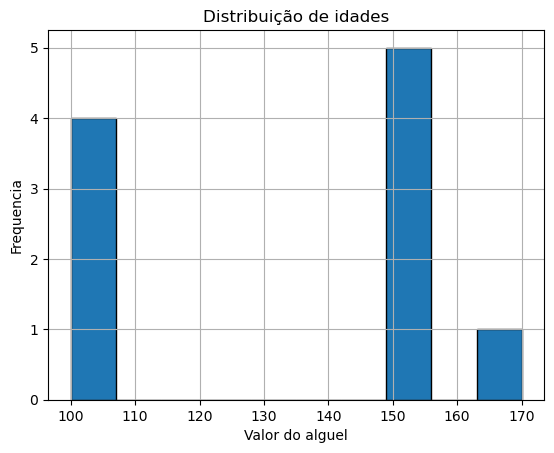

In [20]:
 
df['valor_aluguel'].hist(edgecolor='black')
plt.title('Distribuição de idades')
plt.xlabel('Valor do alguel')
plt.ylabel('Frequencia')
plt.show()


In [21]:
df.columns

Index(['codigo_aluguel', 'data_aluguel', 'nome_cliente', 'cidade_cliente',
       'sexo_cliente', 'estado_cliente', 'estadocivil_cliente', 'modelo_carro',
       'valor_aluguel', 'marca_carro', 'ano_aluguel', 'mes_aluguel',
       'dia_aluguel'],
      dtype='object')

Análise de Séries Temporais

In [22]:
df_resample = df[['data_aluguel', 'valor_aluguel']].set_index('data_aluguel').sort_index()
df_resample

,valor_aluguel
data_aluguel,
2023-04-01,150.0
2023-04-02,100.0
2023-04-03,100.0
2023-04-04,170.0
2023-04-05,150.0
2023-04-13,150.0
2023-04-15,100.0
2023-04-19,150.0
2023-04-21,150.0


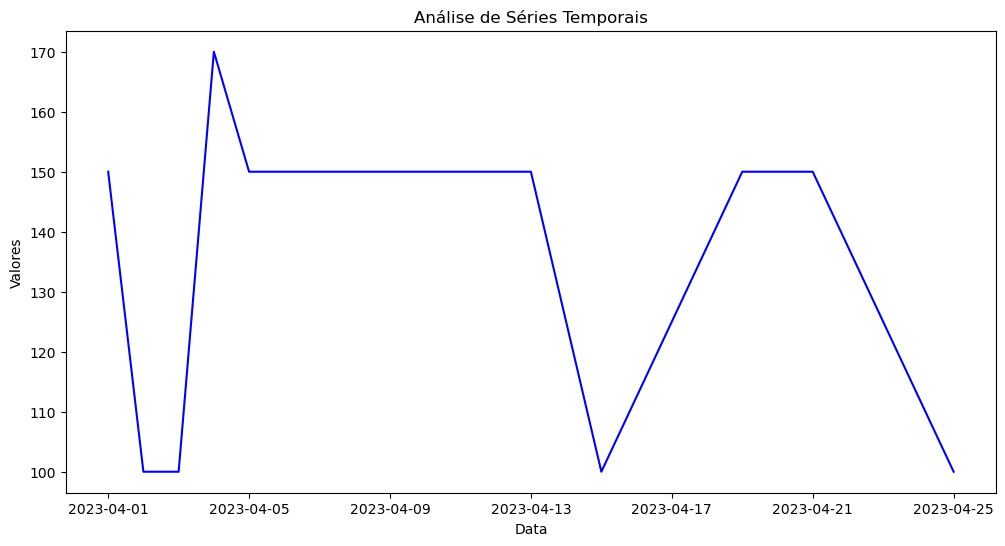

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df_resample.index, df_resample['valor_aluguel'], color='blue')
plt.title('Análise de Séries Temporais')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.show()

### 5.1.4. Carregar o Dataframe Pandas no BigQuery

In [24]:
from google.cloud import bigquery
project_id = 'soulcode-434516'
dataset_id = 'atividade_1_est_bd'

In [25]:
client = bigquery.Client()

In [26]:
def create_dataset_bigQuery(client, dataset_id, location="US"):
    """Cria um dataset no BigQuery.

    Args:
        client: Um objeto cliente do BigQuery.
        dataset_id: O ID do dataset a ser criado.
        location: A localização geográfica do dataset.

    Returns:
        Um objeto Dataset representando o dataset criado.

    Raises:
        Exception: Se ocorrer algum erro durante a criação do dataset.
    """

    dataset_ref = client.dataset(dataset_id)
    dataset = bigquery.Dataset(dataset_ref)
    dataset.location = location

    try:
        dataset = client.create_dataset(dataset)
        print(f"Dataset {dataset.dataset_id} criado com sucesso!")
        return dataset
    except Exception as e:
        raise

In [27]:
# Criar o Dataset
dataset = None
try:
    dataset = create_dataset_bigQuery(client, dataset_id)
except Exception as e:
    print(f"Erro ao criar o dataset: {e}")

Erro ao criar o dataset: 409 POST https://bigquery.googleapis.com/bigquery/v2/projects/soulcode-434516/datasets?prettyPrint=false: Already Exists: Dataset soulcode-434516:atividade_1_est_bd


In [28]:
#TODO: Criar schema Bigquery porem já está formatado com o dataframe pandas
# table_id = "soulcode-434516.atividade_1_est_bd.tb_locadora"
table_locadora_id = f"{project_id}.{dataset_id}.tb_locadora"
if dataset:
    job_config = bigquery.LoadJobConfig(
        write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
    )
    
    job = client.load_table_from_dataframe(df,table_locadora_id, job_config=job_config)
    job.result()
else:
    print('Não criado')


Não criado


In [29]:
query = f"SELECT * FROM `{table_locadora_id}`"

query_job = client.query(query)
results = query_job.result().to_dataframe()
results


/opt/conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,codigo_aluguel,data_aluguel,nome_cliente,cidade_cliente,sexo_cliente,estado_cliente,estadocivil_cliente,modelo_carro,valor_aluguel,marca_carro,ano_aluguel,mes_aluguel,dia_aluguel
0,2,2023-04-02,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,2
1,3,2023-04-03,Bruna Pereira,Niterói,F,RJ,C,Ka,100.0,Ford,2023,4,3
2,7,2023-04-15,Ana Silva,Duque de Caxias,F,RJ,C,Ka,100.0,Ford,2023,4,15
3,10,2023-04-25,Túlio Nascimento,Duque de Caxias,M,RJ,S,Ka,100.0,Ford,2023,4,25
4,1,2023-04-01,Túlio Nascimento,Duque de Caxias,M,RJ,S,Argo,150.0,Fiat,2023,4,1
5,8,2023-04-19,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,19
6,9,2023-04-21,Lúcia Andrade,São Paulo,F,SP,C,Argo,150.0,Fiat,2023,4,21
7,4,2023-04-04,Bruna Pereira,Niterói,F,RJ,C,Onix,170.0,Chevrolet,2023,4,4
8,5,2023-04-05,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen,2023,4,5
9,6,2023-04-13,Ana Silva,Duque de Caxias,F,RJ,C,Polo,150.0,Volkswagen,2023,4,13


## 5.2. Database Logistica

In [30]:
engine = create_engine(f'mysql+pymysql://{USER}:{quote_plus(PASSWORD)}@{HOST}/{DB_LOGISTICA}')
connection = engine.connect()
connection

### 5.2.1 Transformação em DataFrames Pandas

In [31]:
query = """SELECT
    P.ID_Pedido AS Pedido_ID,
    P.Data_Pedido AS data_pedido,
    P.Data_Entrega_Estimada AS data_entrega_estimada,
    P.Data_Entrega_Real AS data_entrega_real,
    P.Distancia_km AS distancia_km,
    P.Custo_Transporte AS custo_transporte,
    P.Peso_kg AS peso_kg,
    P.Regiao AS regiao,
    M.Nome AS nome_motorista,
    M.Idade as idade_motorista,
    M.Tempo_de_Empresa AS tempo_empresa_motorista,
    M.Regiao AS regiao_motorista,
    M.Avaliacao_Desempenho AS avaliacao_desempenho_motorista,
    V.Tipo AS tipo_veiculo,
    V.Capacidade_kg AS capacidade_kg_veiculo,
    V.Custo_Manutencao_Mensal AS custo_manutencao_mensal_veiculo,
    V.Consumo_Combustivel_km_l AS consumo_combustivel_km_l
FROM
    Pedidos P
INNER JOIN Motoristas M ON P.Motorista = M.ID_Motorista
INNER JOIN Veiculos V ON P.Veiculo = V.ID_Veiculo;"""

df = pd.read_sql(query, connection)
df

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,regiao,nome_motorista,idade_motorista,tempo_empresa_motorista,regiao_motorista,avaliacao_desempenho_motorista,tipo_veiculo,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
0,4,2023-01-04,2023-01-08,2023-01-09,602.6720,557.714,449.7840,Justinshire,James Larson,45,6,Lake Nicole,1.12926,Caminhão,986.757,839.116,8.07568
1,8,2023-01-08,2023-01-12,2023-01-13,867.5140,779.996,333.4330,North Sarahaven,Daniel Hunt,55,8,Masontown,4.67671,Caminhão,986.757,839.116,8.07568
2,13,2023-01-13,2023-01-17,2023-01-18,834.1180,936.728,327.7210,North Chelsea,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,986.757,839.116,8.07568
3,19,2023-01-19,2023-01-23,2023-01-24,437.6260,903.303,326.5680,Jamestown,Craig Peterson,27,28,North Curtisland,4.50665,Caminhão,986.757,839.116,8.07568
4,20,2023-01-20,2023-01-24,2023-01-25,298.3170,585.408,425.3660,Davidhaven,Amber Stone,56,8,Martinstad,2.81296,Caminhão,986.757,839.116,8.07568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,61,2023-03-02,2023-03-06,2023-03-07,394.7910,431.005,309.4290,East Dustin,Jennifer Moss,47,28,Hallville,1.65934,Caminhão,112.305,1584.880,12.47250
96,64,2023-03-05,2023-03-09,2023-03-10,363.1860,582.197,261.5730,Nelsonhaven,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.880,12.47250
97,83,2023-03-24,2023-03-28,2023-03-29,337.5890,932.224,190.9140,West Mariamouth,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,112.305,1584.880,12.47250
98,84,2023-03-25,2023-03-29,2023-03-30,72.9228,889.605,51.5211,Alexanderland,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.880,12.47250


### 5.2.2. Tratamento de Dados

In [32]:
df.shape

(100, 17)

In [33]:
df.isnull().sum()

Pedido_ID                          0
data_pedido                        0
data_entrega_estimada              0
data_entrega_real                  0
distancia_km                       0
custo_transporte                   0
peso_kg                            0
regiao                             0
nome_motorista                     0
idade_motorista                    0
tempo_empresa_motorista            0
regiao_motorista                   0
avaliacao_desempenho_motorista     0
tipo_veiculo                       0
capacidade_kg_veiculo              0
custo_manutencao_mensal_veiculo    0
consumo_combustivel_km_l           0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Pedido_ID                        100 non-null    int64         
 1   data_pedido                      100 non-null    datetime64[ns]
 2   data_entrega_estimada            100 non-null    datetime64[ns]
 3   data_entrega_real                100 non-null    datetime64[ns]
 4   distancia_km                     100 non-null    float64       
 5   custo_transporte                 100 non-null    float64       
 6   peso_kg                          100 non-null    float64       
 7   regiao                           100 non-null    object        
 8   nome_motorista                   100 non-null    object        
 9   idade_motorista                  100 non-null    int64         
 10  tempo_empresa_motorista          100 non-null    int64         

In [35]:
df.head()

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,regiao,nome_motorista,idade_motorista,tempo_empresa_motorista,regiao_motorista,avaliacao_desempenho_motorista,tipo_veiculo,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
0,4,2023-01-04,2023-01-08,2023-01-09,602.672,557.714,449.784,Justinshire,James Larson,45,6,Lake Nicole,1.12926,Caminhão,986.757,839.116,8.07568
1,8,2023-01-08,2023-01-12,2023-01-13,867.514,779.996,333.433,North Sarahaven,Daniel Hunt,55,8,Masontown,4.67671,Caminhão,986.757,839.116,8.07568
2,13,2023-01-13,2023-01-17,2023-01-18,834.118,936.728,327.721,North Chelsea,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,986.757,839.116,8.07568
3,19,2023-01-19,2023-01-23,2023-01-24,437.626,903.303,326.568,Jamestown,Craig Peterson,27,28,North Curtisland,4.50665,Caminhão,986.757,839.116,8.07568
4,20,2023-01-20,2023-01-24,2023-01-25,298.317,585.408,425.366,Davidhaven,Amber Stone,56,8,Martinstad,2.81296,Caminhão,986.757,839.116,8.07568


In [36]:
df.tail()

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,regiao,nome_motorista,idade_motorista,tempo_empresa_motorista,regiao_motorista,avaliacao_desempenho_motorista,tipo_veiculo,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
95,61,2023-03-02,2023-03-06,2023-03-07,394.7910,431.005,309.4290,East Dustin,Jennifer Moss,47,28,Hallville,1.65934,Caminhão,112.305,1584.88,12.4725
96,64,2023-03-05,2023-03-09,2023-03-10,363.1860,582.197,261.5730,Nelsonhaven,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.88,12.4725
97,83,2023-03-24,2023-03-28,2023-03-29,337.5890,932.224,190.9140,West Mariamouth,Jason Padilla,36,5,New Jeffreyborough,4.11041,Caminhão,112.305,1584.88,12.4725
98,84,2023-03-25,2023-03-29,2023-03-30,72.9228,889.605,51.5211,Alexanderland,Cassandra Gaines,35,28,Tonychester,2.64502,Caminhão,112.305,1584.88,12.4725
99,89,2023-03-30,2023-04-03,2023-04-04,888.3410,576.686,146.8380,Lake Adrianastad,Amber Stone,56,8,Martinstad,2.81296,Caminhão,112.305,1584.88,12.4725


In [37]:
df.eq(0).sum()

Pedido_ID                          0
data_pedido                        0
data_entrega_estimada              0
data_entrega_real                  0
distancia_km                       0
custo_transporte                   0
peso_kg                            0
regiao                             0
nome_motorista                     0
idade_motorista                    0
tempo_empresa_motorista            0
regiao_motorista                   0
avaliacao_desempenho_motorista     0
tipo_veiculo                       0
capacidade_kg_veiculo              0
custo_manutencao_mensal_veiculo    0
consumo_combustivel_km_l           0
dtype: int64

In [38]:
df = df.drop_duplicates()

### 5.2.3. Análise Estatística Descritiva

In [39]:
df.describe()

,Pedido_ID,data_pedido,data_entrega_estimada,data_entrega_real,distancia_km,custo_transporte,peso_kg,idade_motorista,tempo_empresa_motorista,avaliacao_desempenho_motorista,capacidade_kg_veiculo,custo_manutencao_mensal_veiculo,consumo_combustivel_km_l
count,100.000000,100,100,100,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,50.500000,2023-02-19 12:00:00,2023-02-23 12:00:00,2023-02-24 12:00:00,475.478925,548.04859,261.212665,40.97000,16.930000,2.838906,472.536260,2893.45572,9.479980
min,1.000000,2023-01-01 00:00:00,2023-01-05 00:00:00,2023-01-06 00:00:00,15.466900,106.25700,7.505480,25.00000,4.000000,1.129260,112.305000,839.11600,5.332770
25%,25.750000,2023-01-25 18:00:00,2023-01-29 18:00:00,2023-01-30 18:00:00,201.268750,317.80425,142.055250,36.00000,8.000000,2.039800,157.161000,2200.33000,5.703450
50%,50.500000,2023-02-19 12:00:00,2023-02-23 12:00:00,2023-02-24 12:00:00,469.501000,555.06250,283.465000,40.00000,17.000000,2.655790,446.377500,3018.86500,8.440025
75%,75.250000,2023-03-16 06:00:00,2023-03-20 06:00:00,2023-03-21 06:00:00,732.901000,789.56550,377.421500,45.00000,26.000000,3.324650,774.620000,3794.30500,12.472500
max,100.000000,2023-04-10 00:00:00,2023-04-14 00:00:00,2023-04-15 00:00:00,987.018000,987.08500,495.077000,59.00000,28.000000,4.762130,986.757000,4609.25000,18.173300
std,29.011492,NaN,NaN,NaN,294.514511,263.80012,145.246050,8.27245,8.638948,1.075924,320.086021,1155.22145,3.957608


### 5.2.4. Carregar o Dataframe Pandas no BigQuery

In [40]:

table_locadora_id = f"{project_id}.{dataset_id}.tb_logistica"

job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)
    
job = client.load_table_from_dataframe(df,table_locadora_id, job_config=job_config)
job.result()

LoadJob<project=soulcode-434516, location=US, id=8eff45f4-9717-4c53-a24e-12424d0ff3c2>

# Referencias
- https://cloud.google.com/bigquery/docs/visualize-jupyter